In [1]:
import os
import numpy as np

import tensorflow as tf
import keras

from keras.applications import VGG16, VGG19, ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imagenet_utils import decode_predictions
from imagenet_utils import preprocess_input

from tqdm import tqdm
import glob

Using TensorFlow backend.


# Data Prep

### Using ImageDataGenerator.

Eventually want to use args and argparse to take in train_dir and test_dir.

In [2]:
train_dir = 'train_CAL/'
test_dir = 'test_CAL/'

In [3]:
IM_HEIGHT = 224
IM_WIDTH = 224
NB_EPOCHS = 1
BAT_SIZE = 16
FC_SIZE = 500 # May need to train this parameter
nb_classes = 1

In [4]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

In [5]:
nb_train_samples = get_nb_files(train_dir)
nb_classes = len(glob.glob(train_dir + "/*"))
nb_val_samples = get_nb_files(test_dir)

# VGG Model

In [6]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x)
    predictions = Dense(nb_classes, activation='sigmoid')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    for layer in base_model.layers:
        layer.trainable = False
        model.compile(optimizer='adam',    
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

In [28]:
# ignore this for now
def setup_to_finetune(model):
    """
    If we want to fine-tine
    """
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]: # need to declare num layers to train
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001, momentum=0.9),   
                 loss='binary_crossentropy')

Need to tune:
* architecture type (ResNet, Inception, VGG19)
* FC_SIZE
* Adam parameters (momentum, learning rate, etc)
* image data generator transforming parameters

In [8]:
def prepare_training(train_dir, test_dir, imheight=IM_HEIGHT, imwidth=IM_WIDTH, batch=BAT_SIZE):
    train_datagen =  ImageDataGenerator(
    #rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)
    
    test_datagen = ImageDataGenerator(
        #rotation_range=30,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=BAT_SIZE
    )
    validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=BAT_SIZE
    )
    
    return (train_generator, validation_generator)

In [13]:
def vgg16_train(train_dir, val_dir):
    
    train_gen, val_gen = prepare_training(train_dir=train_dir, test_dir=test_dir)

    base_model = VGG16(weights='imagenet', include_top=False)
    #base_model = VGG16(weights=None, include_top=False)
    
    model = add_new_last_layer(base_model, nb_classes)

    setup_to_transfer_learn(model, base_model)

    history = model.fit_generator(train_gen, epochs = NB_EPOCHS, steps_per_epoch = nb_train_samples, \
                                     validation_data=val_gen, validation_steps = nb_val_samples)
    model.save("vgg19.h5")
    
    return history

h = vgg16_train(train_dir, test_dir)

Found 362 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Epoch 1/1
 12/720 [..............................] - ETA: 4:38:40 - loss: 6.3493 - acc: 0.40 - ETA: 4:15:12 - loss: 7.1603 - acc: 0.45 - ETA: 4:08:23 - loss: 7.4306 - acc: 0.46 - ETA: 3:59:18 - loss: 7.5657 - acc: 0.47 - ETA: 3:53:21 - loss: 7.6468 - acc: 0.48 - ETA: 3:51:09 - loss: 7.7009 - acc: 0.48 - ETA: 3:46:24 - loss: 7.7395 - acc: 0.48 - ETA: 3:45:36 - loss: 7.7685 - acc: 0.48 - ETA: 3:44:26 - loss: 7.7910 - acc: 0.48 - ETA: 3:35:43 - loss: 7.8090 - acc: 0.49 - ETA: 3:36:58 - loss: 7.8238 - acc: 0.49 - ETA: 3:36:37 - loss: 7.8360 - acc: 0.4922

KeyboardInterrupt: 

In [9]:
def vgg19_train(train_dir, val_dir):
    
    train_gen, val_gen = prepare_training(train_dir=train_dir, test_dir=test_dir)

    base_model = VGG19(weights='imagenet', include_top=False)
    model = add_new_last_layer(base_model, nb_classes)

    setup_to_transfer_learn(model, base_model)

    history = model.fit_generator(train_gen, epochs = NB_EPOCHS, steps_per_epoch = nb_train_samples, \
                                     validation_data=val_gen, validation_steps = nb_val_samples)
    model.save("vgg19.h5")
    
    return history

h = vgg19_train(train_dir, test_dir)

Found 720 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
80142336/80134624 [==============================] - ETA: 14:1 - ETA: 9:3 - ETA: 8: - ETA: 6: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 56 - ETA: 53 - ETA: 50 - ETA: 48 - ETA: 44 - ETA: 43 - ETA: 41 - ETA: 39 - ETA: 38 - ETA: 36 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 19 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

In [16]:
def resnet_train(train_dir, val_dir):
    
    train_gen, val_gen = prepare_training(train_dir=train_dir, test_dir=test_dir)

    base_model = ResNet50(weights='imagenet', include_top=False)
    model = add_new_last_layer(base_model, nb_classes)

    setup_to_transfer_learn(model, base_model)

    history = model.fit_generator(train_gen, epochs = NB_EPOCHS, steps_per_epoch = nb_train_samples, \
                                     validation_data=val_gen, validation_steps = nb_val_samples)
    model.save("resnet.h5")
    
    return history

h = resnet_train(train_dir, test_dir)

Found 720 images belonging to 2 classes.
Found 140 images belonging to 2 classes.
Epoch 1/1
  4/720 [..............................] - ETA: 4:53:50 - loss: 0.8471 - acc: 0.28 - ETA: 3:45:25 - loss: 1.5609 - acc: 0.45 - ETA: 3:21:04 - loss: 1.2564 - acc: 0.59 - ETA: 3:08:15 - loss: 1.1657 - acc: 0.6328

KeyboardInterrupt: 

In [8]:
def predict(test_dir, model):
    from keras.models import load_model
    test_datagen = ImageDataGenerator()
    
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle=False
    )
    
    model = load_model(model) # i.e. vgg16.h5
    pred = model.predict_generator(test_generator, steps=len(test_generator))
    
    return pred

preds = predict('./val_CAL', 'resnet_2048_32.h5')

Found 140 images belonging to 2 classes.


In [24]:
def get_labels(direc):
    # direc = "./val_CAL"
    folder = direc + "/0"
    num0 = len(os.listdir(direc + '/0'))
    num1 = len(os.listdir(direc + '/1'))
    y_real = list(np.repeat(0, num0)) + list(np.repeat(1, num1))
    
    return y_real

In [4]:
def decode(preds):
    classes = []

    for img in preds:
        if img[0] >= img[1]:
            classes.append(0)
        else:
            classes.append(1)
            
    return classes

In [25]:
y_real = get_labels('val_CAL')

classes = decode(preds)

num_correct = 0
for i in range(len(classes)):
    if classes[i] == y_real[i]:
        num_correct += 1

total_acc = num_correct / len(classes)
print(total_acc)

0.8142857142857143


In [41]:
def convert_to_two(vec):
    two_vec = np.zeros((140, 2))
    for i in range(len(vec)):
        if vec[i] == 0:
            two_vec[i][0] = 1
        else:
            two_vec[i][1] = 1
    return two_vec

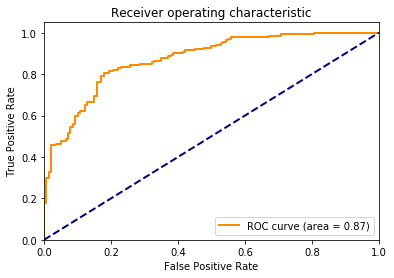

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true = convert_to_two(y_real)
fpr, tpr, _ = roc_curve(y_true.ravel(), preds.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

fig2 = plt.gcf()
plt.show()
fig2.savefig("ROC.jpg")

In [52]:
def get_roc_curve(model, val_dir, fname):
    
    y_pred = predict(val_dir, model)
    
    y_real = get_labels(val_dir)

    y_true = convert_to_two(y_real)
    
    fpr, tpr, _ = roc_curve(y_true.ravel(), preds.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    fig2 = plt.gcf()
    plt.show()
    fig2.savefig(fname)

In [ ]:
get_roc_curve('resnet_2048_16_none.h5', 'val_CAL', 'roc_16.jpg')

Found 140 images belonging to 2 classes.
